# Section 8: Textured Si

This example is based on Figures 6, 7 and 8 from [this paper](https://doi.org/10.1364/OE.23.0A1720).
This compares three different structures, all based on a 200 micron thick slab of silicon
with different surface textures:

1. Planar front surface (TMM), crossed grating at rear (RCWA)
2. Inverted pyramids on the front surface (RT_Fresnel), planar rear surface (TMM)
3. Inverted pyramids on the front surface (RT_Fresnel), crossed grating at rear (RCWA)

The methods which will be used to calculate the redistribution matrices in each case are given in
brackets. If case 1 and 2 are calculated first, then case 3 does not require the calculations of
any additional matrices, since it will use the rear matrix from (1) and the front matrix from (2).

## Setting up

First, importing relevant packages:

In [1]:
import numpy as np
import os

# solcore imports
from solcore.structure import Layer
from solcore import material
from solcore import si

from rayflare.structure import Interface, BulkLayer, Structure
from rayflare.matrix_formalism import process_structure, calculate_RAT
from rayflare.utilities import get_savepath
from rayflare.transfer_matrix_method import tmm_structure
from rayflare.angles import theta_summary, make_angle_vector
from rayflare.textures import regular_pyramids
from rayflare.options import default_options

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sparse import load_npz

Setting options (taking the default options for everything not specified explicitly):

In [2]:
angle_degrees_in = 8 # same as in Fraunhofer paper

wavelengths = np.linspace(900, 1200, 20) * 1e-9

Si = material("Si")()
Air = material("Air")()

options = default_options()
options.wavelengths = wavelengths
options.theta_in = angle_degrees_in * np.pi / 180 # incidence angle (polar angle)
options.n_theta_bins = 50
options.c_azimuth = 0.25
options.n_rays = 5e5 # number of rays per wavelength in ray-tracing
options.project_name = "OPTOS_comparison"
options.orders = 60 # number of RCWA orders to use (more = better convergence, but slower)
options.pol = "u" # unpolarized light
options.only_incidence_angle = False
options.RCWA_method = "Inkstone"


## Defining the structures

Now, set up the grating basis vectors for the RCWA calculations and define the grating structure.
These are squares, rotated by 45 degrees. The halfwidth is calculated based on the area fill factor
of the etched pillars given in the paper.

In [3]:
x = 1000

d_vectors = ((x, 0), (0, x))
area_fill_factor = 0.36
hw = np.sqrt(area_fill_factor) * 500

back_materials = [
    Layer(width=si("120nm"), material=Si,
        geometry=[{"type": "rectangle", "mat": Air, "center": (x / 2, x / 2),
                "halfwidths": (hw, hw), "angle": 45}],
    )]

Now we define the pyramid texture for the front surface in case (2) and (3) and make the four
possible different surfaces: planar front and rear, front with pyramids, rear with grating.
We specify the method to use to calculate the redistribution matrices in each case and create
the bulk layer.

In [4]:
surf = regular_pyramids(elevation_angle=55, upright=False)

front_surf_pyramids = Interface(
    "RT_Fresnel",
    texture=surf,
    layers=[],
    name="inv_pyramids_front_" + str(options["n_rays"]),
)

front_surf_planar = Interface("TMM", layers=[], name="planar_front")

back_surf_grating = Interface(
    "RCWA",
    layers=back_materials,
    name="crossed_grating_back",
    d_vectors=d_vectors,
    rcwa_orders=20,
)

back_surf_planar = Interface("TMM", layers=[], name="planar_back")

bulk_Si = BulkLayer(200e-6, Si, name="Si_bulk")

Now we create the different structures and 'process' them (this will calculate the relevant
matrices if necessary, or do nothing if it finds the matrices have previously been calculated and
the files already exist). We don't need to process the final structure because it will use matrices
calculated for `SC_fig6` and `SC_fig7`.

In [5]:
SC_fig6 = Structure(
    [front_surf_planar, bulk_Si, back_surf_grating], incidence=Air, transmission=Air
)
SC_fig7 = Structure(
    [front_surf_pyramids, bulk_Si, back_surf_planar], incidence=Air, transmission=Air
)
SC_fig8 = Structure(
    [front_surf_pyramids, bulk_Si, back_surf_grating], incidence=Air, transmission=Air
)

process_structure(SC_fig6, options, save_location='current')
process_structure(SC_fig7, options, save_location='current')

Making matrix for planar surface using TMM for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
RCWA calculation for element 2 in structure
Existing angular redistribution matrices found
Ray tracing with Fresnel equations for element 0 in structure
Existing angular redistribution matrices found
Existing angular redistribution matrices found
Making matrix for planar surface using TMM for element 2 in structure
Existing angular redistribution matrices found


## Calculating R/A/T

Then we ask RayFlare to calculate the reflection, transmission and absorption through matrix
multiplication, and get the required result out (absorption in the bulk) for each cell. We
also load the results from the reference paper to compare them to the ones calculated with RayFlare.

In [6]:
#| output: false

results_fig6 = calculate_RAT(SC_fig6, options, save_location='current')
results_fig7 = calculate_RAT(SC_fig7, options, save_location='current')
results_fig8 = calculate_RAT(SC_fig8, options, save_location='current')

RAT_fig6 = results_fig6[0]
RAT_fig7 = results_fig7[0]
RAT_fig8 = results_fig8[0]

sim_fig6 = np.loadtxt("data/optos_fig6_sim.csv", delimiter=",")
sim_fig7 = np.loadtxt("data/optos_fig7_sim.csv", delimiter=",")
sim_fig8 = np.loadtxt("data/optos_fig8_sim.csv", delimiter=",")

After iteration 1 : maximum power fraction remaining = 0.30465596465807976
After iteration 2 : maximum power fraction remaining = 0.2652222497842741
After iteration 3 : maximum power fraction remaining = 0.24104359214306953
After iteration 4 : maximum power fraction remaining = 0.2216247810938919
After iteration 5 : maximum power fraction remaining = 0.204445503162972
After iteration 6 : maximum power fraction remaining = 0.18895596333010428
After iteration 7 : maximum power fraction remaining = 0.17490875091250335
After iteration 8 : maximum power fraction remaining = 0.16216012784735218
After iteration 9 : maximum power fraction remaining = 0.15059635548444156
After iteration 10 : maximum power fraction remaining = 0.1401131916998427
After iteration 11 : maximum power fraction remaining = 0.13061203418124748
After iteration 12 : maximum power fraction remaining = 0.12200024528955256
After iteration 13 : maximum power fraction remaining = 0.11419190864535754
After iteration 14 : maxim

Finally, we use TMM to calculate the absorption in a structure with a planar front and planar rear,
as a reference.

In [7]:
struc = tmm_structure([Layer(si("200um"), Si)], incidence=Air, transmission=Air)
options.coherent = False
options.coherency_list = ["i"]
RAT = tmm_structure.calculate(struc, options)

## Plotting

Plot everything together, including data from the reference paper for comparison:

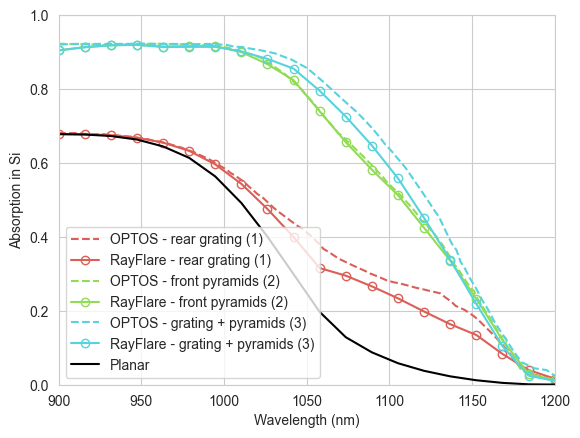

In [8]:
palhf = sns.color_palette("hls", 4)

fig = plt.figure()
plt.plot(sim_fig6[:, 0], sim_fig6[:, 1],
    "--", color=palhf[0], label="OPTOS - rear grating (1)")
plt.plot(wavelengths * 1e9, RAT_fig6["A_bulk"][0],
    "-o", color=palhf[0], label="RayFlare - rear grating (1)", fillstyle="none")
plt.plot(sim_fig7[:, 0], sim_fig7[:, 1],
    "--", color=palhf[1], label="OPTOS - front pyramids (2)",)
plt.plot(wavelengths * 1e9, RAT_fig7["A_bulk"][0],
    "-o", color=palhf[1], label="RayFlare - front pyramids (2)", fillstyle="none")
plt.plot(sim_fig8[:, 0], sim_fig8[:, 1],
    "--", color=palhf[2], label="OPTOS - grating + pyramids (3)")
plt.plot(wavelengths * 1e9, RAT_fig8["A_bulk"][0],
    "-o", color=palhf[2],label="RayFlare - grating + pyramids (3)", fillstyle="none",)
plt.plot(wavelengths * 1e9, RAT["A_per_layer"][:, 0], "-k", label="Planar")
plt.legend(loc="lower left")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorption in Si")
plt.xlim([900, 1200])
plt.ylim([0, 1])
plt.show()

We can see good agreement between the reference values and our calculated values. The structure
with rear grating also behaves identically to the planar TMM reference case at the short wavelengths
where front surface reflection dominates the result, as expected. Clearly, the pyramids perform
much better overall, giving a large boost in the absorption at long wavelengths and also reducing the reflection
significantly at shorter wavelengths. Plotting reflection and transmission emphasises this:

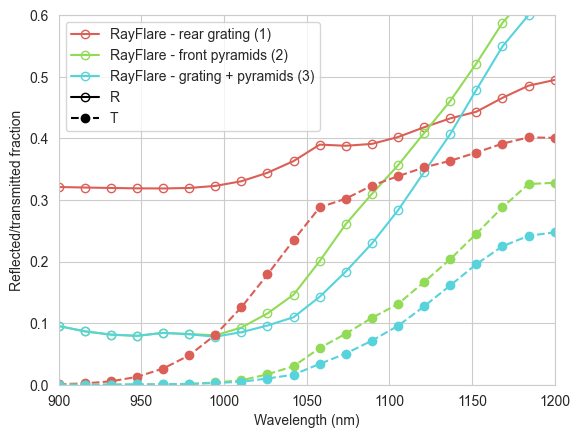

In [9]:
fig = plt.figure()
plt.plot(wavelengths * 1e9,RAT_fig6["R"][0],
    "-o", color=palhf[0], label="RayFlare - rear grating (1)", fillstyle="none")
plt.plot(wavelengths * 1e9, RAT_fig7["R"][0],
    "-o", color=palhf[1], label="RayFlare - front pyramids (2)", fillstyle="none")
plt.plot(wavelengths * 1e9, RAT_fig8["R"][0],
    "-o", color=palhf[2], label="RayFlare - grating + pyramids (3)", fillstyle="none")

plt.plot(wavelengths * 1e9, RAT_fig6["T"][0], "--o", color=palhf[0])
plt.plot(wavelengths * 1e9, RAT_fig7["T"][0], "--o", color=palhf[1])
plt.plot(wavelengths * 1e9, RAT_fig8["T"][0], "--o", color=palhf[2])

# these are just to create the legend:
plt.plot(-1, 0, "k-o", label="R", fillstyle="none")
plt.plot(-1, 0, "k--o", label="T")

plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflected/transmitted fraction")
plt.xlim([900, 1200])
plt.ylim([0, 0.6])
plt.show()

## Redistribution matrices

Plot the redistribution matrix for the rear grating (summed over azimuthal angles) at 1100 nm:

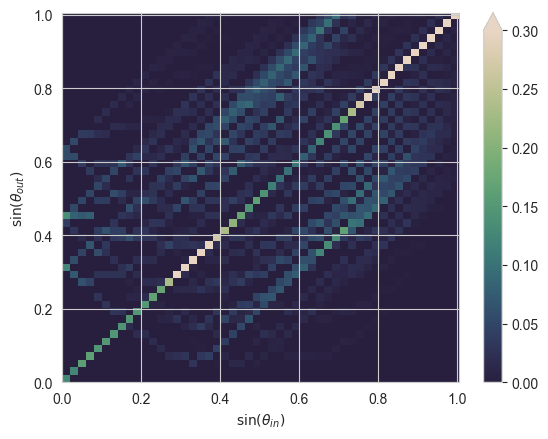

In [10]:
theta_intv, phi_intv, angle_vector = make_angle_vector(
    options["n_theta_bins"], options["phi_symmetry"], options["c_azimuth"])

path = get_savepath(save_location='current', project_name=options.project_name)
sprs = load_npz(os.path.join(path, SC_fig6[2].name + "frontRT.npz"))

wl_to_plot = 1100e-9
wl_index = np.argmin(np.abs(wavelengths - wl_to_plot))

full = sprs[wl_index].todense()

summat = theta_summary(full, angle_vector, options["n_theta_bins"], "front")
summat_r = summat[: options["n_theta_bins"], :]
summat_r = summat_r.rename({ r"$\theta_{in}$": r"$\sin(\theta_{in})$",
        r"$\theta_{out}$": r"$\sin(\theta_{out})$"})

summat_r = summat_r.assign_coords({r"$\sin(\theta_{in})$": np.sin(summat_r.coords[r"$\sin(\theta_{in})$"]).data,
    r"$\sin(\theta_{out})$": np.sin(summat_r.coords[r"$\sin(\theta_{out})$"]).data})

palhf = sns.cubehelix_palette(256, start=0.5, rot=-0.9)
palhf.reverse()
seamap = mpl.colors.ListedColormap(palhf)

fig = plt.figure()
ax = plt.subplot(111)
ax = summat_r.plot.imshow(ax=ax, cmap=seamap, vmax=0.3)
plt.show()

## Questions

- If you can add only one of the textures (pyramids or a grating), which one is
  better? Why?
- Why do the structures with a front-surface texture have high reflection at long
  wavelengths? The anti-reflection properties of pyramids (treated with ray optics)
  are mostly independent of the wavelength, so why does apparent reflection increase
  near the bandgap of Si?
- Can you explain any of the features present in the angular redistribution matrix
  of the rear grating surface?